In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
from PIL import Image

from time import sleep

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
selenium.__version__

'3.141.0'

## Parameters

In [3]:
SITE_ROOT = 'https://jdi-testing.github.io/jdi-light/'
DRIVER_FILE = 'geckodriver.exe'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = False


In [4]:
if platform.system()=='Windows':
    
    if os.path.isfile(DRIVER_FILE):
        path = set(os.environ['PATH'].split(';'))
        path.add(os.getcwd())
        os.environ['PATH'] = ';'.join(path).strip(';')

In [5]:
print(os.environ['PATH'])

C:\Users\vyach\AppData\Local\Microsoft\WindowsApps;C:\WINDOWS\System32\Wbem;C:\Windows\system32;D:\Anaconda3\envs\py37-torch;C:\ProgramData\DockerDesktop\version-bin;C:\Anaconda3\Scripts;C:\Anaconda3\Library\bin;C:\openshift;D:\Anaconda3\envs\py37-torch\Library\usr\bin;C:\Anaconda3;C:\ProgramData\chocolatey\bin;C:\Program Files\Docker\Docker\resources\bin;C:\cuda\bin;C:\cuda8\bin;D:\Anaconda3\Library\bin;C:\Windows\System32\Wbem;C:\WINDOWS\system32;C:\Program Files\Git\cmd;D:\Anaconda3\envs\py37-torch\Library\mingw-w64\bin;D:\DataScience\SELENIUM;D:\Anaconda3\Library\usr\bin;D:\Anaconda3\Scripts;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin;C:\Anaconda3\Library\mingw-w64\bin;C:\WINDOWS;C:\minishift;C:\Windows;C:\VSCode\bin;D:\Anaconda3\envs\py37-torch\Library\bin;C:\WINDOWS\System32\WindowsPowerShell\v1.0;D:\Anaconda3\Library\mingw-w64\bin;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\NVIDIA Corporation\Nsight Compute 2019.4.0;D:\Anaconda3;D:\Anacon

## Create driver (HEADLESS)

In [6]:
options = selenium.webdriver.FirefoxOptions()
options.headless = HEADLESS

In [7]:
driver = Firefox(executable_path= os.path.join(os.getcwd(),'geckodriver.exe'), options=options)
driver.get(SITE_ROOT)

In [8]:
driver.get_window_position(), driver.get_window_size(), driver.title

({'x': 4, 'y': 4}, {'width': 1296, 'height': 975}, 'Home Page')

## Maximize window

In [9]:
# Maximize window
def maximize_window(driver=driver):
    S = lambda X: driver.execute_script('return document.body.parentNode.scroll' + X )
    driver.set_window_size(S('Width'), S('Height'))
    driver.find_element_by_tag_name('body')
    print('Window maximized')


## Take Screenshot

In [10]:
def screenshot(driver=driver, display:bool = False):

    if not SAVE_SCREEN:
        return None

    fn = str(datetime.now())+".png"
    fn = fn.replace(':','_').replace(' ',"T")
    
    if not driver.save_screenshot(fn):
        print('cannot save screenshot')
    
    img = plt.imread(fn)
    if display:
        plt.imshow(img)
        
    return img

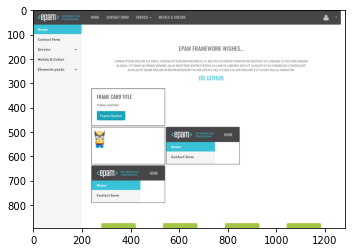

In [11]:
plt.imshow(screenshot(driver))

In [12]:
maximize_window()

Window maximized


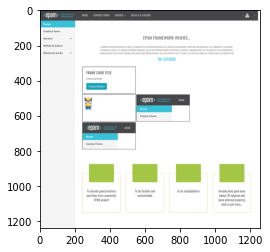

In [13]:
plt.imshow(screenshot(driver))

## Login

In [14]:
driver.find_element_by_id("user-icon").click()
driver.find_element_by_id("name").send_keys(LOGIN)
driver.find_element_by_id("password").send_keys(PASSWORD)
driver.find_element_by_id("login-button").click()
sleep(WAIT_TIME_SECONDS)

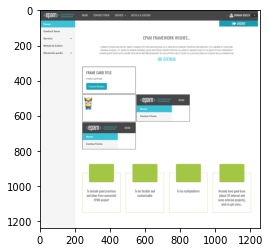

In [15]:
plt.imshow(screenshot(driver))

## Get All elements

In [16]:
def get_all_elements(driver=driver):
    
    elements_all = driver.find_elements_by_xpath('//*')
    # maximize_window(driver=driver)
    
    columns = [
        'tag_name',
        'x',
        'y',
        'height',
        'width',
        'displayed',
        'enabled',
        'selected',
        'text'
    ]

    elements_a = []

    for e in elements_all:
        txt = e.get_attribute('text')
        elements_a.append([
            e.tag_name,
            e.location['x'],
            e.location['y'],
            e.size['height'],
            e.size['width'],
            e.is_displayed(),
            e.is_enabled(),
            e.is_selected(),
            txt
        ])

    e_df = pd.DataFrame(elements_a)
    e_df.columns = columns
    return e_df

In [17]:
%%time
elements_df = get_all_elements()
elements_df

Wall time: 5.34 s


,tag_name,x,y,height,width,displayed,enabled,selected,text
0,html,0,0,1239.0,1238.000000,True,True,False,None
1,head,0,0,0.0,0.000000,False,True,False,None
2,meta,0,0,0.0,0.000000,False,True,False,None
3,title,0,0,0.0,0.000000,False,True,False,Home Page
4,meta,0,0,0.0,0.000000,False,True,False,None
...,...,...,...,...,...,...,...,...,...
223,li,1136,1280,15.0,2.899994,True,True,False,None
224,li,1154,1280,15.0,64.100006,True,True,False,None
225,a,1154,1280,15.0,64.100006,True,True,False,Report a bug
226,script,0,0,0.0,0.000000,False,True,False,"\n UUI.Vertical_Menu.init({""open"": true..."


In [18]:
img = screenshot()

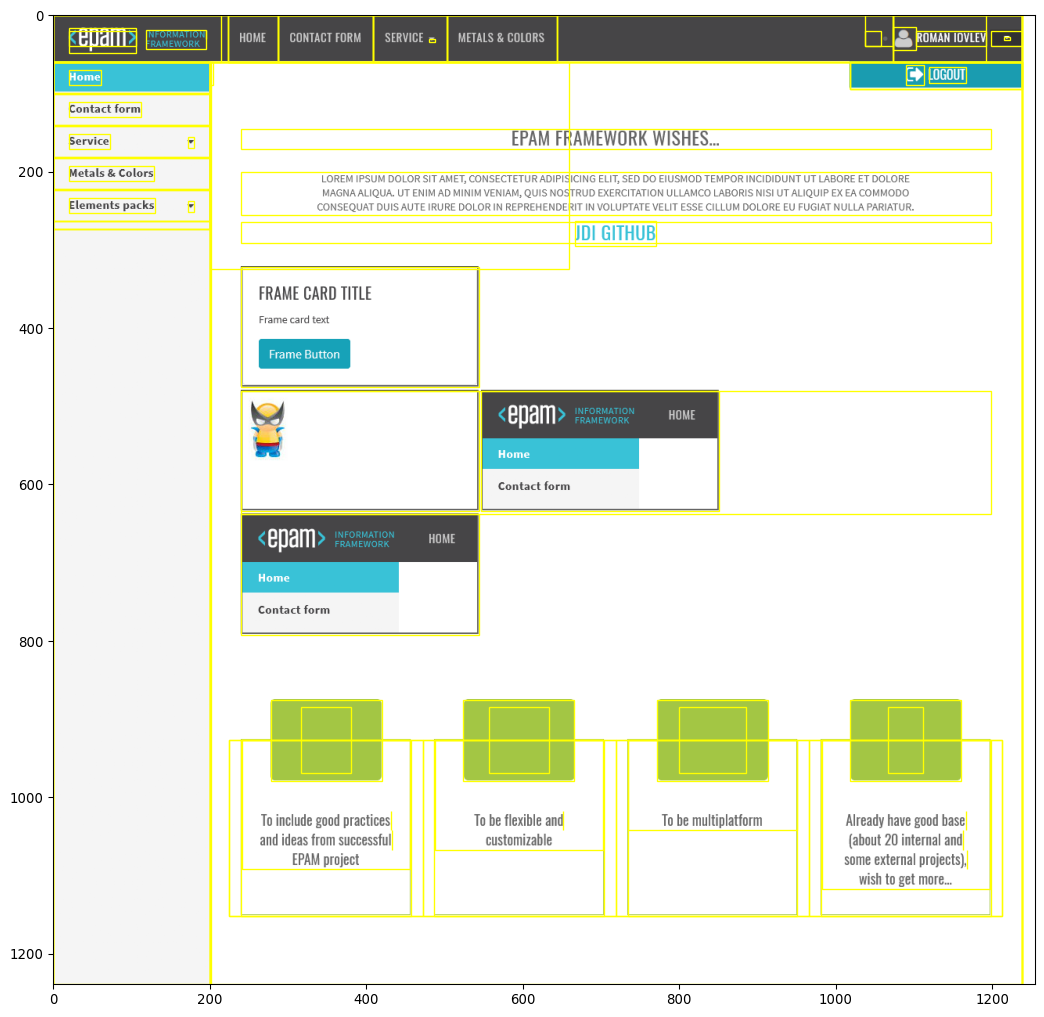

In [19]:
w = driver.get_window_size()['width']
h = driver.get_window_size()['height']

my_dpi = 96
plt.figure(figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

plt.imshow(img)
ax = plt.gca()

for i, r in elements_df[(elements_df.width>0) & (elements_df.height>0)].iterrows():
    patch = patches.Rectangle((r.x, r.y), r.width, r.height, linewidth = 1, edgecolor = 'yellow', facecolor='none')
    ax.add_patch(patch)
    
plt.savefig('annotated.png')

In [20]:
# links_a = driver.find_elements_by_xpath('//*//a')
# links_a

In [21]:
driver.find_element(By.LINK_TEXT, "Elements packs").click()
driver.find_element(By.LINK_TEXT, "HTML 5").click()
sleep(WAIT_TIME_SECONDS)

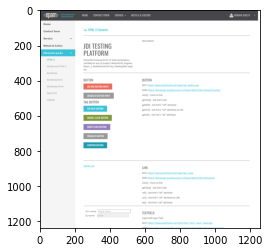

In [22]:
plt.imshow(screenshot(driver))

In [23]:
maximize_window()
sleep(WAIT_TIME_SECONDS)

Window maximized


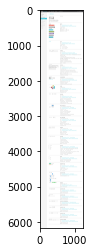

In [24]:
img=screenshot(driver)
plt.imshow(img)

In [25]:
%%time
elements_df = get_all_elements()
elements_df

Wall time: 15.5 s


,tag_name,x,y,height,width,displayed,enabled,selected,text
0,html,0,0,6167.0,1209.0,True,True,False,None
1,head,0,0,0.0,0.0,False,True,False,None
2,meta,0,0,0.0,0.0,False,True,False,None
3,title,0,0,0.0,0.0,False,True,False,HTML 5
4,meta,0,0,0.0,0.0,False,True,False,None
...,...,...,...,...,...,...,...,...,...
657,script,0,0,0.0,0.0,False,True,False,\n function show_val(element) {\n\t\tconst ...
658,script,0,0,0.0,0.0,False,True,False,\n $('#multi-dropdown').multiselect();\n
659,script,0,0,0.0,0.0,False,True,False,"\n UUI.Vertical_Menu.init({""open"":true});\n"
660,script,0,0,0.0,0.0,False,True,False,\n $('.selectpicker').selectpicker();\n


In [26]:
driver.get_window_size()

{'width': 1238, 'height': 6247}

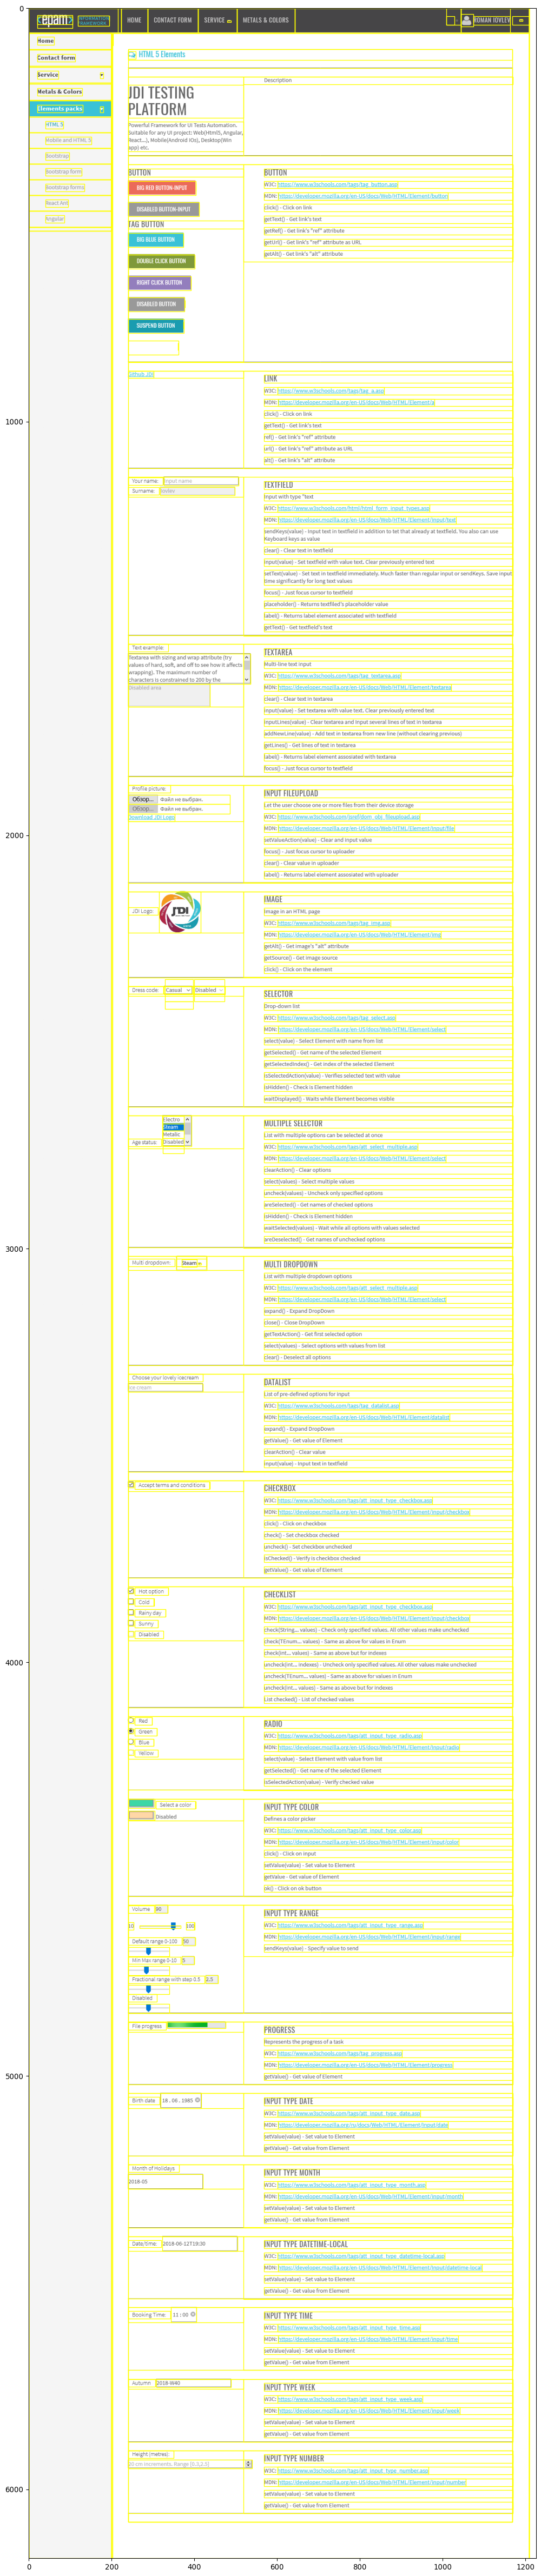

In [27]:
w = driver.get_window_size()['width']
h = driver.get_window_size()['height']

my_dpi = 96
plt.figure(figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)

plt.imshow(img)
ax = plt.gca()

for i, r in elements_df[(elements_df.width>0) & (elements_df.height>0)].iterrows():
    patch = patches.Rectangle((r.x, r.y), r.width, r.height, linewidth = 1, edgecolor = 'yellow', facecolor='none')
    ax.add_patch(patch)
    
plt.savefig('annotated1.png')

In [28]:
def is_hover(e, driver=driver):
    ActionChains(driver).move_to_element(driver.find_element_by_xpath('//body')).perform()
    sleep(.5)
    _before = e.screenshot_as_base64
    # print(_before)
    hover = ActionChains(driver).move_to_element(e)
    hover.perform()
    sleep(.5)
    _after = e.screenshot_as_base64
    # print(_after)
    return _after != _before
    
    

In [29]:
ActionChains(driver).move_to_element(driver.find_element_by_xpath('//body')).perform()

In [30]:
e = driver.find_element(By.LINK_TEXT, "Angular")
is_hover(e)

True

In [51]:
element_list = []

for e in driver.find_elements_by_xpath('//*'):
    if (e.rect['width'] + e.rect['height']) > 0:
        element_list.append({
            'tag': e.tag_name,
            ** e.rect
        })
        #print(e.tag_name, e.rect)
        
tags_df = pd.DataFrame(element_list)

In [53]:
tags_df.groupby('tag').size()

tag
a            66
b             1
body          1
br           32
button        7
div          95
footer        1
h1            1
h4           24
header        1
html          1
i             1
img           3
input        34
label        32
li           20
main          1
nav           1
option       17
p           142
progress      1
select        4
span         21
textarea      2
ul            5
dtype: int64